# Find signature areas with and without missing signatures with ImageMagick, Tesseract and Keras

We want to find contract pages that have signature areas with missing signatures. Our strategy is to use Tesseract to search for typical words such as "som kjøper" and "som selger" that usually appear near a signature field, extract a "signature area" image around these words, and classify them as "containing a signature" or "not containing a signature".

In [1]:
import os, glob
import numpy as np
import random
import pytesseract
from PIL import Image, ImageDraw, ImageFont
from bs4 import BeautifulSoup as soup
import matplotlib.pyplot as plt

Let's generate a text file with bounding boxes from the image we want to detect signatures in:
![](02.png)

In [8]:
def hocr_pdf(pdf_file_name,temp_file_name = "temp_pdf_png"):
    os.system("rm {0}*".format(temp_file_name))
    os.system("convert -density 300 -depth 8 -quality 85 {0} temp_pdf_png.png".format(pdf_file_name))
    png_files = glob.glob("{0}*.png".format(temp_file_name))
    
    for png_file in png_files:
        file = png_file.replace(".png","")
        os.system("tesseract -l nor {0} {1} hocr".format(png_file, file))
    
    hocr_files = sorted(glob.glob("temp_pdf_png*.hocr"))
    
    return(hocr_files)

In [7]:
hocr_pdf("synth_contracts.pdf")

['temp_pdf_png-0.hocr',
 'temp_pdf_png-1.hocr',
 'temp_pdf_png-2.hocr',
 'temp_pdf_png-3.hocr',
 'temp_pdf_png-4.hocr',
 'temp_pdf_png-5.hocr',
 'temp_pdf_png-6.hocr',
 'temp_pdf_png-7.hocr',
 'temp_pdf_png-8.hocr',
 'temp_pdf_png-9.hocr']

In [14]:
with open("temp_pdf_png-5.hocr","r") as file:
    hocr = soup(file, "html5lib")

We use beautifulsoup to find the elements containing the keywords we want to trigger signature detection in, for this example we use "selger:" and "kjøper:"

In [15]:
selger = hocr.find_all("span", string="selger:")
kjøper = hocr.find_all("span", string="kjøper:")

Let's extract the top left corner of each signature field:

In [16]:
def get_coords(sig_list):
    
    coord_list = []
    for sig in sig_list:
        word_list = str(sig).replace(";","").split(" ")
        bbox_idx = word_list.index('title="bbox')
        x0 = np.int(word_list[bbox_idx+1])
        y0 = np.int(word_list[bbox_idx+2])
        x1 = np.int(word_list[bbox_idx+3])
        y1 = np.int(word_list[bbox_idx+4])

        coord_list.append((x0,y0,x1,y1))
    return(coord_list)

In [17]:
selger_coords = get_coords(selger)
kjøper_coords = get_coords(kjøper)

In [18]:
selger_coords, kjøper_coords

([(1322, 6841, 1816, 6988)],
 [(1734, 2460, 2369, 2641), (6122, 7507, 6688, 7669)])

Let's extract images of each detected signature field. We'll use the font size (from the height of the bounding box) to scale the extracted area: The larger the font, the larger the extracted image:

In [19]:
def extract_signatures(page_file, coord_list):
    
    page_img = Image.open(page_file)
    page_width = page_img.size[0]
    page_height=page_img.size[1]

    sig_img_list = []
    for coords in coord_list:
        
        x0,y0,x1,y1 = coords
        
        font_height = y1-y0
        
        x0 = np.max([x0 - font_height*3, 0])
        x1 = np.min([x0 + font_height*10, page_width])
        y1 = np.min([y0 + font_height*6, page_height])
        
        crop_img = page_img.crop((x0,y0,x1,y1))
        sig_img_list.append(crop_img)
    
    return(sig_img_list)

In [22]:
selger_img_list = extract_signatures("temp_pdf_png-5.png", selger_coords)
kjøper_img_list = extract_signatures("temp_pdf_png-5.png", kjøper_coords)

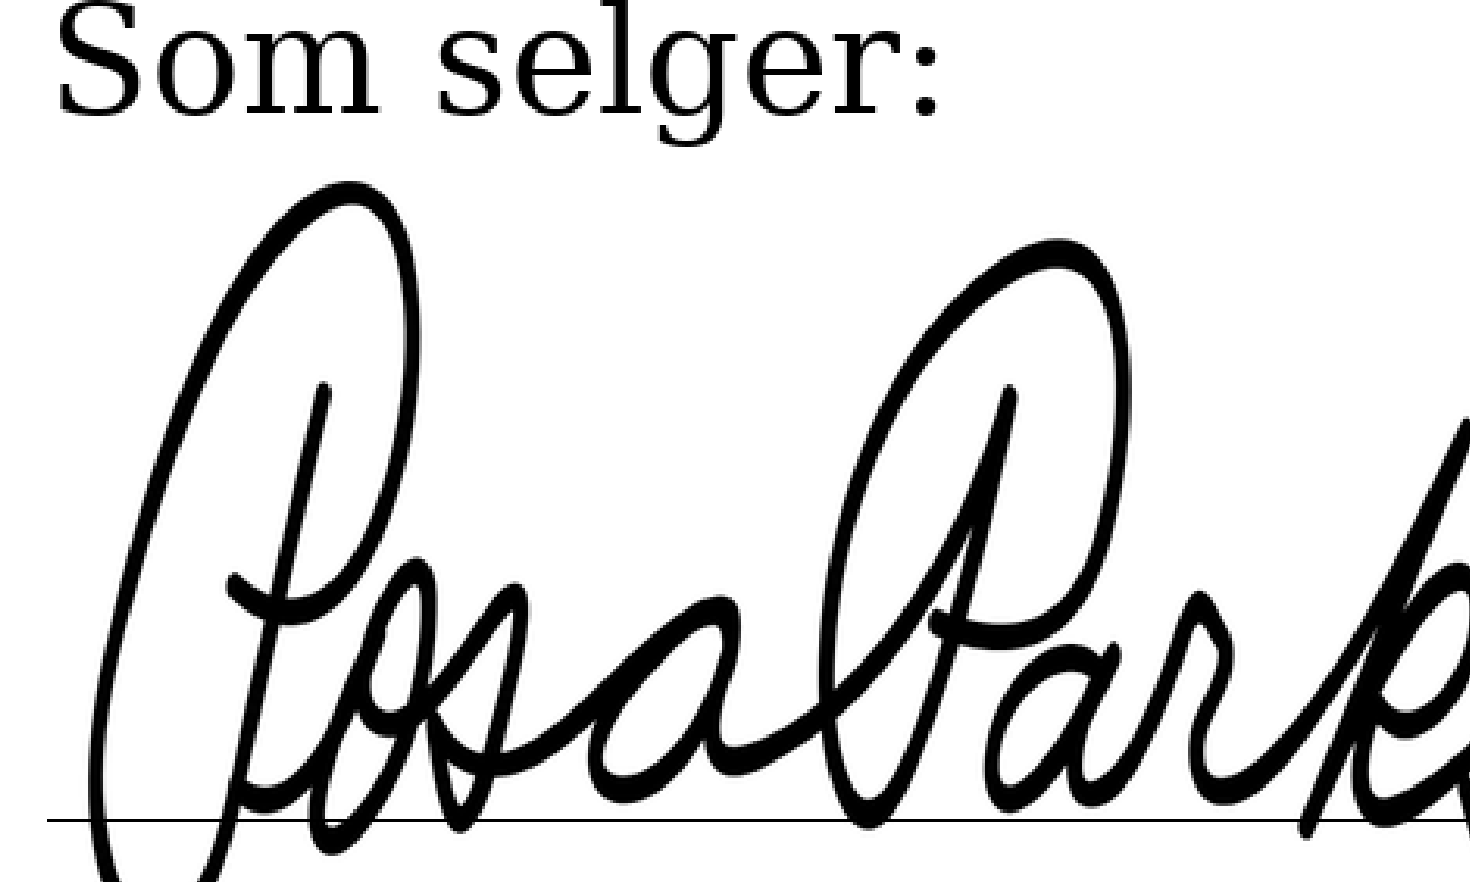

In [23]:
selger_img_list[0]

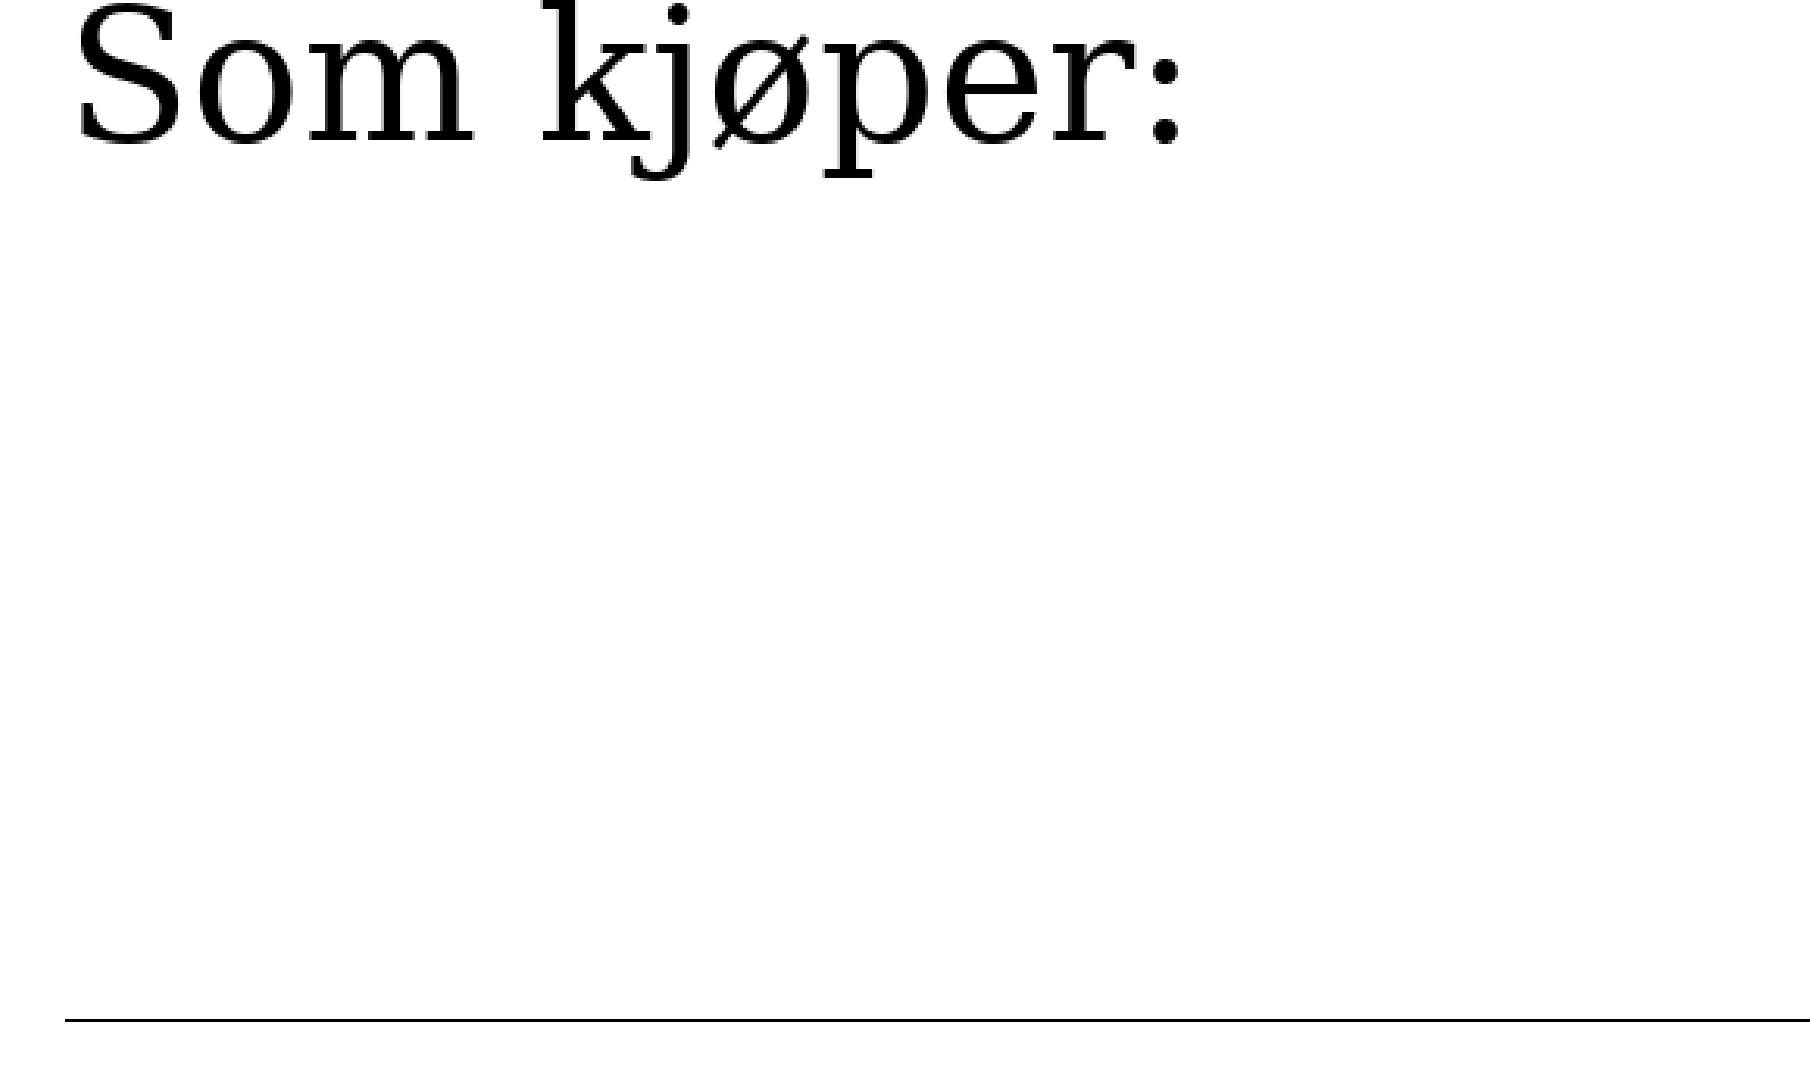

In [25]:
kjøper_img_list[0]

This works pretty well! Our next step is to build a training data set for the neural net that will decide if each image contains a signature. We'll generate a bunch of signature areas of various sizes, with and without signatures:

In [26]:
def generate_signature(width, height, filename):
    
    img = Image.open(filename)
    new_width  = width
    new_height = height
    img = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    return(img)


def signature_box_content(width, height, text, signed=False, sig_directory="signatures", font="DejaVuSerif.ttf"):
    
    bottom_margin = np.int(np.max([np.round(height*0.15),1]))
    
    sig_img = Image.new("RGB", (width,height), color="white")
    
    draw = ImageDraw.Draw(sig_img)
    
    draw.line((0, sig_img.size[1]-bottom_margin, sig_img.size[0], sig_img.size[1]-bottom_margin), fill="black")
    
    fnt_size = bottom_margin
    txt_fnt = ImageFont.truetype(font, fnt_size)
    draw.text((0,0), text, font=txt_fnt, fill="black")
    
    if signed:
        
        sig_filename = random.choice(os.listdir(sig_directory))
        #print(sig_filename) Uncomment to debug signature.png-s with bad transparency masks
        signature = generate_signature(width, height-bottom_margin, sig_directory+"/"+sig_filename)
        sig_img.paste(signature, (0,bottom_margin), signature)
        
    return(sig_img, bottom_margin)

In [13]:
def generate_signatures(N,
                        pct_validate=0.1,
                        path="signature_output/",
                        signed_probability=0.5,
                        signature_width_min = 200,
                        signature_width_max = 600,
                        signature_height_min= 100,
                        signature_height_max= 400,
                        font = "DejaVuSerif.ttf", # TODO: Randomly sample fonts from folder
                        font_size_min = 20,
                        font_size_max = 50):

    N_length = len(str(N))
    
    for n in range(0,(N)):
        
        height = np.random.randint(low=signature_height_min, high=signature_height_max)
        width = np.random.randint(low=signature_width_min, high=signature_width_max)
        
        box_is_signed = np.random.rand()<signed_probability
        
        if np.random.rand()>0.5:
            sign_box_text = "Som kjøper:"
        else:
            sign_box_text = "Som selger:"
            
        sig_img, _ = signature_box_content(width, height, sign_box_text, box_is_signed)
        
        #n_string = str(n+1).zfill(N_length)
        n_string = str(n+1)
        
        N_train = np.int(N*(1-pct_validate))

        if n<N_train:
            if box_is_signed:
                   sig_img.save(path+"train/signed/"+n_string+".png")
            else:
                   sig_img.save(path+"train/not_signed/"+n_string+".png")
        else:
            if box_is_signed:
                   sig_img.save(path+"validation/signed/"+n_string+".png")
            else:
                   sig_img.save(path+"validation/not_signed/"+n_string+".png")
        
        if (n+1) % 1000 == 0:
            print(str(n+1) + " of " +str(N))
            
    return("Done! Synthetic signatures written to "+path)

In [16]:
generate_signatures(1000)

1000 of 1000


'Done! Synthetic signatures written to signature_output/'

Now let's see if we can teach a small CNN to tell the difference between signed signature areas and signature areas with missing signatures (see https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html for details):

In [163]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'signature_output/train'
validation_data_dir = 'signature_output/validation'
nb_train_samples = 900
nb_validation_samples = 100
epochs = 20
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

#model.save_weights('first_try.h5')
model.save('model.h5')

Found 900 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/20
56/56 [==============================] - 20s 349ms/step - loss: 0.2826 - acc: 0.8918 - val_loss: 2.5208e-06 - val_acc: 1.0000
Epoch 2/20
56/56 [==============================] - 18s 329ms/step - loss: 0.5050 - acc: 0.9632 - val_loss: 5.3124e-06 - val_acc: 1.0000
Epoch 3/20
56/56 [==============================] - 19s 333ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 1.0820e-07 - val_acc: 1.0000
Epoch 4/20
56/56 [==============================] - 19s 342ms/step - loss: 0.0896 - acc: 0.9911 - val_loss: 9.1169 - val_acc: 0.4271
Epoch 5/20
56/56 [==============================] - 20s 360ms/step - loss: 0.1867 - acc: 0.9877 - val_loss: 1.0820e-07 - val_acc: 1.0000
Epoch 6/20
56/56 [==============================] - 20s 352ms/step - loss: 1.7057e-04 - acc: 1.0000 - val_loss: 1.0820e-07 - val_acc: 1.0000
Epoch 7/20
56/56 [==============================] - 19s 348ms/step - loss: 0.1525 - acc: 0.9888 

Let's try our model on the signatures we found in the example page:

In [27]:
from keras.models import load_model
from keras.preprocessing import image

def predict_image(model_name, img, threshold=0.5, show=False):

    img = img.convert('RGB')
    
    img = img.resize((150, 150), Image.ANTIALIAS)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    
    model = load_model(model_name)
    
    pred = model.predict(img_tensor)
    
    if pred[0]<threshold:
        conclusion = "Not signed!"
    else:
        conclusion = "Signed!"
        
    return conclusion, np.round(np.float(pred[0]),4)

Using TensorFlow backend.


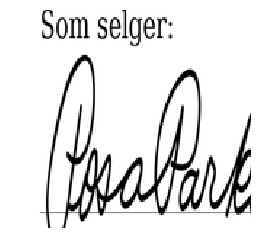

('Signed!', 1.0)

In [28]:
predict_image("model.h5",selger_img_list[0],show=True)

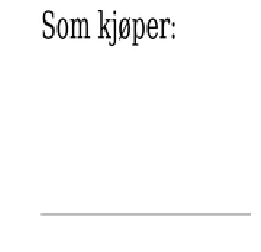

('Not signed!', 0.0)

In [29]:
predict_image("model.h5",kjøper_img_list[0],show=True)

Easy peasy! But what about real cases not based on synthetic data? Let's give it a go on this contract example from Eiendomsmegler 1:
![](eiendomsmegler1_kontrakt.png)

In [23]:
!tesseract -l nor eiendomsmegler1_kontrakt.png eiendomsmegler1_kontrakt hocr

Tesseract Open Source OCR Engine v3.04.01 with Leptonica


In [30]:
with open("eiendomsmegler1_kontrakt.hocr","r") as file:
    hocr = soup(file, "html5lib")

selger = hocr.find_all("span", string="selger:")
kjøper = hocr.find_all("span", string="kjøper:")

selger_coords = get_coords(selger)
kjøper_coords = get_coords(kjøper)

selger_img_list = extract_signatures("eiendomsmegler1_kontrakt.png", selger_coords)
kjøper_img_list = extract_signatures("eiendomsmegler1_kontrakt.png", kjøper_coords)

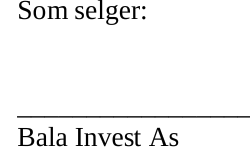

In [31]:
selger_img_list[0]

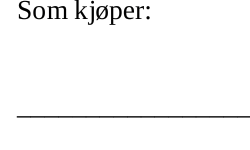

In [32]:
kjøper_img_list[0]

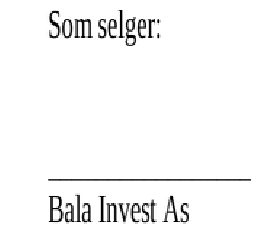

('Not signed!', 0.0)

In [33]:
predict_image("model.h5",selger_img_list[0],show=True)

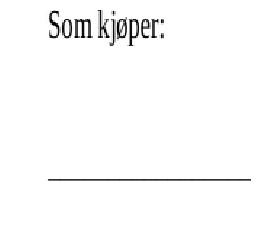

('Not signed!', 0.0)

In [34]:
predict_image("model.h5",kjøper_img_list[0],show=True)

Looking good! Now what if we sign this contract by hand, with a signature not earlier seen by the model during training?
![](eiendomsmegler1_kontrakt_signed.png)

In [29]:
!tesseract -l nor eiendomsmegler1_kontrakt_signed.png eiendomsmegler1_kontrakt_signed hocr

Tesseract Open Source OCR Engine v3.04.01 with Leptonica


In [35]:
with open("eiendomsmegler1_kontrakt_signed.hocr","r") as file:
    hocr = soup(file, "html5lib")

selger = hocr.find_all("span", string="selger:")
kjøper = hocr.find_all("span", string="kjøper:")

selger_coords = get_coords(selger)
kjøper_coords = get_coords(kjøper)

selger_img_list = extract_signatures("eiendomsmegler1_kontrakt_signed.png", selger_coords)
kjøper_img_list = extract_signatures("eiendomsmegler1_kontrakt_signed.png", kjøper_coords)

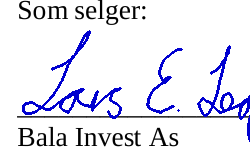

In [36]:
selger_img_list[0]

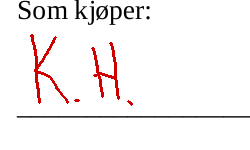

In [37]:
kjøper_img_list[0]

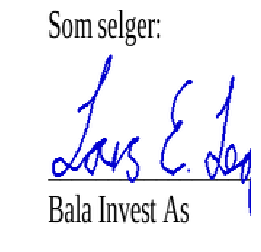

('Signed!', 1.0)

In [38]:
predict_image("model.h5",selger_img_list[0],show=True)

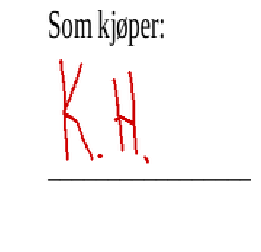

('Signed!', 0.9998)

In [39]:
predict_image("model.h5",kjøper_img_list[0],show=True)

Hell yeah!

*Todo: Write script that takes pdf as input, splits pages into png images, runs ocr on each page, runs signature detect on each signature, then outputs a dict of signature metadata for the pdf. Then, wrap everything in Flask, put it in a Docker image, deploy to AWS free tier, and open for outside access.*

For the next step we define a function that takes a list of "trigger words" that we believe are associated with a signature area, gathers coordinates for each trigger word from each hocr file, and returns everything in a dictionary:

In [40]:
def get_trigger_areas(hocr_list,
                      trigger_words = ["kjøper:",
                                       "selger:",
                                       "underskrift:"]):
    trigger_dict = {}
    
    page_num=0
    for hocr_file in hocr_list:
        page_num+=1
        with open(hocr_file,"r") as file:
            hocr = soup(file, "html5lib")
        
        for trigger_word in trigger_words:
            n=0
            trigger_list = hocr.find_all("span", string=trigger_word)
            
            for trigger in trigger_list:
                n+=1
                word_list = str(trigger).replace(";","").split(" ")
                bbox_idx = word_list.index('title="bbox')
                x0 = np.int(word_list[bbox_idx+1])
                y0 = np.int(word_list[bbox_idx+2])
                x1 = np.int(word_list[bbox_idx+3])
                y1 = np.int(word_list[bbox_idx+4])
                
                trigger_dict.update({trigger_word+str(n) : {"page":page_num,"x0":x0, "y0":y0,"x1":x1,"y1":y1}})
    return(trigger_dict)

In [42]:
get_trigger_areas(hocr_pdf("forbrukerrådet_kontrakt.pdf"))

{'underskrift:1': {'page': 5, 'x0': 250, 'y0': 2595, 'x1': 397, 'y1': 2617},
 'underskrift:2': {'page': 5, 'x0': 249, 'y0': 2703, 'x1': 397, 'y1': 2725}}

For each trigger in the trigger_dict we use our CNN-model to judge if there's a signature close by. We use a slightly modified version of the "predict_image" helper function:

In [43]:
from keras.models import load_model
from keras.preprocessing import image

def predict_image(model_name, img, threshold=0.5, show=False):

    img = img.convert('RGB')
    
    img = img.resize((150, 150), Image.ANTIALIAS)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    
    model = load_model(model_name)
    
    pred = model.predict(img_tensor)
    
    if pred[0]<threshold:
        conclusion = False # "Not signed!"
        confidence = (threshold-pred)/threshold
    else:
        conclusion = True # "Signed!"
        confidence = (pred-threshold)/(1-threshold)
    
    return conclusion, np.round(confidence,4)

In [48]:
def score_signatures(trigger_dict, 
                     rel_left=3,
                     rel_right=10,
                     rel_up=0,
                     rel_down=6,
                     model="model.h5",
                     temp_file_name="temp_pdf_png"):
    
    for trigger in trigger_dict:
        page_file  = temp_file_name + "-" + str(trigger_dict[trigger]["page"]-1) + ".png"
        page_img   = Image.open(page_file)
        page_width = page_img.size[0]
        page_height= page_img.size[1]
        
        x0 = trigger_dict[trigger]["x0"]
        x1 = trigger_dict[trigger]["x1"]
        y0 = trigger_dict[trigger]["y0"]
        y1 = trigger_dict[trigger]["y1"]
        
        font_height = y1-y0
        
        x0 = np.max([x0 - font_height*rel_left, 0])
        x1 = np.min([x0 + font_height*rel_right, page_width])
        y0 = np.max([y0 - font_height*rel_up, 0])
        y1 = np.min([y0 + font_height*rel_down, page_height])
        
        crop_img = page_img.crop((x0,y0,x1,y1))
        
        signed, confidence = predict_image(model,crop_img,show=False)
        
        trigger_dict[trigger].update({"x0":x0,
                                      "x1":x1,
                                      "y0":y0,
                                      "y1":y1,
                                      "signed":signed, 
                                      "confidence":np.float(confidence)})
    
    return(trigger_dict)

Now let's put everything together:

In [45]:
def score_pdf(pdf_file_name):
    hocr_files = hocr_pdf(pdf_file_name)
    trigger_dict = get_trigger_areas(hocr_files)
    score_dict = score_signatures(trigger_dict)
    
    return(score_dict)

Let's try our scoring function on Forbrukerrådet's recommended contract, with and without signatures. We expect the signatures to be on page 5:

In [209]:
score_pdf("forbrukerrådet_kontrakt.pdf")

{'underskrift:1': {'page': 5,
  'x0': 184,
  'y0': 2595,
  'x1': 404,
  'y1': 2727,
  'signed': False,
  'confidence': 1.0},
 'underskrift:2': {'page': 5,
  'x0': 183,
  'y0': 2703,
  'x1': 403,
  'y1': 2835,
  'signed': False,
  'confidence': 1.0}}

This is really all we need! But... wouldn't it be cool to also return the PDF with the signature detections marked? Yeah, let's give it a try:

In [51]:
import img2pdf

def visualize_detections(trigger_dict, out_filename="viz_detections.pdf", temp_file_name = "temp_pdf_png"):
    
    for trigger in trigger_dict:
        
        page_file  = temp_file_name + "-" + str(trigger_dict[trigger]["page"]-1) + ".png"
        img = Image.open(page_file).convert("RGB")
        drawing = ImageDraw.Draw(img)
        
        top_left = (trigger_dict[trigger]["x0"],trigger_dict[trigger]["y0"])
        bottom_right= (trigger_dict[trigger]["x1"],trigger_dict[trigger]["y1"])
        
        outline_width = 10

        fnt_size = 30
        txt_fnt  = ImageFont.truetype("DejaVuSerif.ttf", fnt_size)

        if trigger_dict[trigger]["signed"]==True:
            color="green"
            text = str(trigger)+" Conclusion: Signed! Confidence: " + str(trigger_dict[trigger]["confidence"])
        else:
            color="red"
            text = str(trigger)+" Conclusion: Not signed! Confidence: " + str(trigger_dict[trigger]["confidence"])

        drawing.rectangle([top_left, bottom_right], outline=color)
        drawing.text(top_left, text, font=txt_fnt, fill=color)
        
        img.save(page_file)
        
        img_list = sorted(glob.glob("{0}*.png".format(temp_file_name)))
        with open(out_filename, "wb") as f:
            f.write(img2pdf.convert(img_list))
            
    return("Done! Visualized detections written to " + out_filename)

In [216]:
forbruker_dict = score_pdf("forbrukerrådet_kontrakt.pdf")
visualize_detections(forbruker_dict, "forbruker_viz.pdf")

'Done! Visualized detections written to forbruker_viz.pdf'